In [1]:
%matplotlib inline
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import pandas as pd
import calendar
import numpy.ma as ma

import createFolder as cF
import plot_vertical as pvert
import plot_sfc_spaghetti as spagh
import fill_values as fv


import os

In [2]:
# 16th doesnt exist, 17-19 have different shapes
t = [
    1#, 2, 3, 4, 5, 6 , 7, 8, 9,10#, \
    #11,12,13,14,15,    
    #17,18,19,20, \
    #21,22,  
    # 23#, \
    #24,25,26,27,28,29,30, \
    #31
    ]
year = 2016
month = 12
savefig = 0  # 1 = yes, 0 = no

In [3]:
ncdir = '../dataMEPS/snowfall_amount'
ncdir_ml = '../dataMEPS/snowfall_amount_ml'
figdir = '../MEPS_fig'
form = 'png'
 

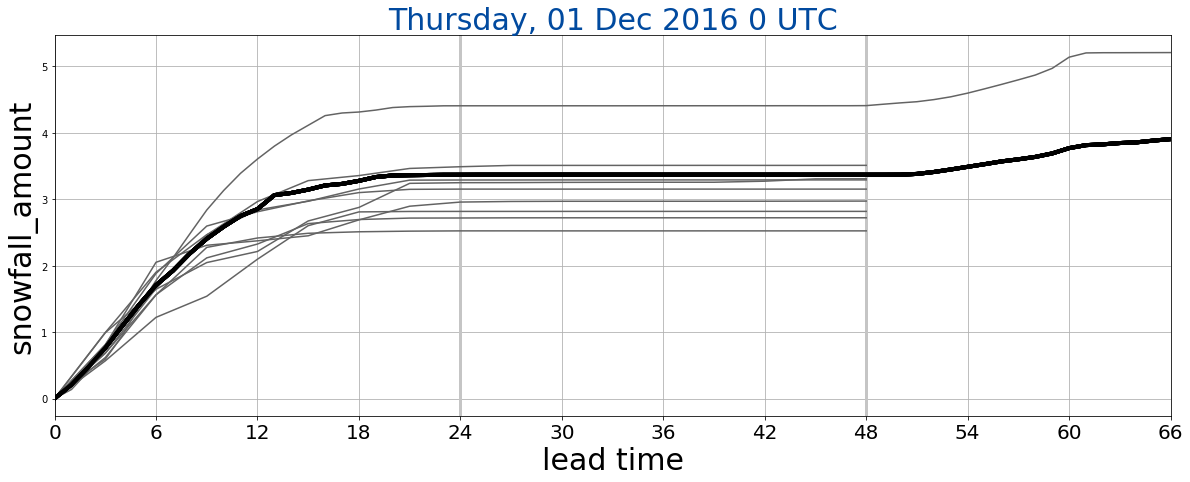

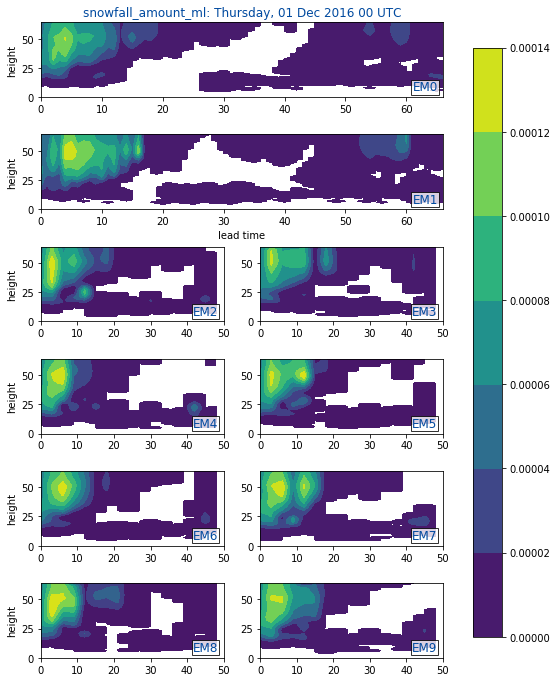

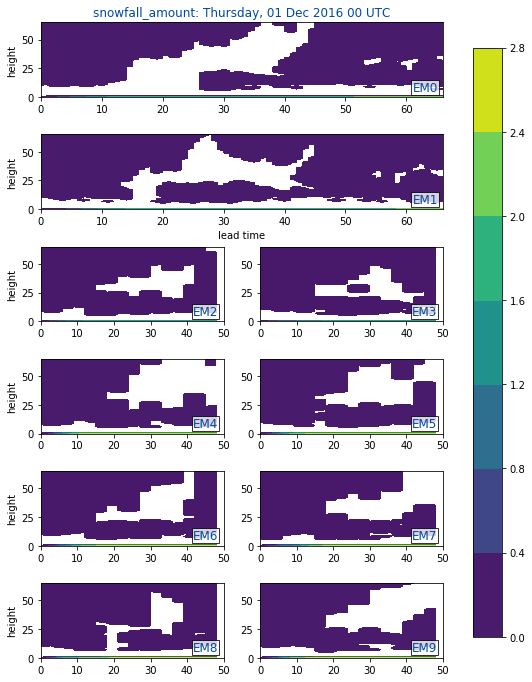

In [4]:
for day in t:
    if day < 10:
        day = '0%s' %(str(day))


## open netCDF    
    fn_sfc = netCDF4.Dataset('%s/%s%s%s.nc' %(ncdir,year,month,day))
    fn_ml = dict()
    
    for ens_memb in range(0,10):
        if ens_memb == 9:
            fn_ml[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s.nc' %(ncdir_ml,year,month,day,ens_memb+1))#
        else:
            fn_ml[ens_memb] = netCDF4.Dataset('%s/%s%s%s_0%s.nc' %(ncdir_ml,year,month,day,ens_memb+1))
    
# Read in time to know initialisation time (plotting)    
    time_sfc = fn_sfc.variables['time']
    time_ml = dict()
    for ens_memb in range(0,10):
        time_ml[ens_memb] = fn_ml[ens_memb].variables['time']

    ini_day = datetime.datetime.utcfromtimestamp(time_sfc[0]).day   # day of initialisation
    hh = datetime.datetime.utcfromtimestamp(time_sfc[0]).hour       # first hour of initialisation? 
    my_date = date(year,month,ini_day)
    calday = calendar.day_name[my_date.weekday()]
    calmon = calendar.month_abbr[int(month)]
    

# Read in the variable name which should be plotted  
    var_name = 'snowfall_amount'
    var_name_0m = '%s' %(var_name)
    SA_0m = fn_sfc.variables[var_name_0m]

    var_name_ml = '%s_ml' %(var_name)
    SA_ml = dict()
    for ens_memb in range(0,10):
        SA_ml[ens_memb] = fn_ml[ens_memb].variables[var_name_ml]
    

# Read in the hybrid height and calculate the thickness of a layer
    hybrid = fn_ml[0].variables['hybrid_height']
    height = hybrid[:]*65
    height = np.append([0], [height])
    height = np.append([height], [65])
    dh = np.empty(height.size-1)
    dh[:] = np.nan

    for i in range(0,66):
        dh[i] = height[i+1]-height[i]



# Create list avoiding the missing values 
# only needed when only model levels are plot
    SA_0m_filled = dict()       # snow amount at surface
    SA_0m_masked = dict()       # snow amount at surface where values exist
    SA_ml_filled = dict()       # snow amount in model levels
    SA_ml_masked = dict()       # snow amount in model levels where values exist

    for ens_memb in range(0,10):
        SA_0m_filled[ens_memb] = fv.filled_val_sfc(SA_0m,ens_memb)
        SA_0m_masked[ens_memb] = np.isfinite(SA_0m_filled[ens_memb])
    
        SA_ml_filled[ens_memb] = fv.filled_val_ml(SA_ml[ens_memb],ens_memb)
        SA_ml_masked[ens_memb] = ma.masked_where(np.isnan(SA_ml_filled[ens_memb]),SA_ml_filled[ens_memb])
    

# connect the surface snowfall with the model levels array
    df1 = dict()
    df2 = dict()
    frames = dict()
    SA_con = dict()
    SA = dict()
    
    for ens_memb in range(0,10):
        df1[ens_memb] = pd.DataFrame.from_dict(SA_0m_filled[ens_memb])     # zeroth ensemble member
        df2[ens_memb] = pd.DataFrame.from_dict(SA_ml_filled[ens_memb])     # zeroth ensemble member
        frames[ens_memb] = [df1[ens_memb], df2[ens_memb]]
        SA_con[ens_memb] = pd.concat(frames[ens_memb],axis = 1)            # connect the array of surface val with 
                                                                           # model level val
        #print(SA_con[ens_memb])
        SA[ens_memb] = dh*SA_con[ens_memb]



# Folder where the figures are being saved    
    cF.createFolder('%s/%s/' %(figdir,var_name))
    
    

    lead_time_sfc = np.arange(0,time_sfc.size)
#
    if ini_day < 10:
        ini_day = '0%s' %(ini_day)
# spaghetti plot with all ensemble member + control
    fig_name = '%s%s%s_0%s_sfc.png' %(year,month,ini_day,hh)
    title = '%s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    spagh.spaghetti_sfc(lead_time_sfc,SA_0m_filled,SA_0m_masked,var_name_0m, title,savefig,
                            figdir, fig_name, form)
    
    plt.close()
        
        

# vertical plot only model levels without surface
    model_level = np.arange(0,SA_ml_filled[0].shape[1])
    lead_time_ml = np.arange(0,time_ml[0].size)

    fig_name = '%s%s%s_0%s_ml.png' %(year,month,ini_day,hh)
    title = '%s: %s, %s %s %s 0%s UTC' %(var_name_ml, calday,ini_day,calmon,year,hh)
    pvert.plot_vertical_EM(lead_time_ml, model_level, SA_ml_masked, var_name,fig_name,title,savefig,
                              figdir, fig_name, form)
    
    plt.close()
        
# vertical plot model levels plus surface values
    model_level = np.arange(0,SA[0].shape[1])
    lead_time_ml = np.arange(0,time_ml[0].size)

    fig_name = '%s%s%s_0%s.png' %(year,month,ini_day,hh)
    title = '%s: %s, %s %s %s 0%s UTC' %(var_name, calday,ini_day,calmon,year,hh)
    pvert.plot_vertical_EM(lead_time_ml, model_level, SA, var_name, fig_name, title, savefig,
                              figdir, fig_name, form)
    plt.close()
   

    if savefig == 1:
        print('figure: %s saved' %(fig_name))
    fn_sfc.close()
    for ens_memb in range(0,10):
        fn_ml[ens_memb].close()